# Exporing the Eyesea sample dataset

This notebook is for initial exploration of the Eyesea sample dataset of 766 images (~1GB).

The local environment set up is detailed in the README file of this repo. We essentially just need to install `pytorch`, `fastai` and `jupyterlab`.

1. Load our sample data.
2. Train a model - fine-tune an existing model because the sample data set is small.
3. Check the model's performance on some out-of-sample images.
4. Ensembling - train a few more models and stack them.
5. Identifying mislabelled examples.
6. Data augmentation
7. Further research.


## 0. Point at your sample data

This *should* be the only cell you need to modify to run this notebook. 

**Change DATA_DIR to be wherever you've saved the sample images**

In [1]:
DATA_DIR = "/Volumes/2TB_SSD/ML_Projects/Eyesea/sample_data_full"

## 1. Data loaders for sample images

Load our sample data and manually check a few examples.

In [2]:
from pathlib import Path

from fastai.vision.all import (
    Image, download_images, resize_images,
    verify_images, get_image_files,
    vision_learner, ImageBlock, CategoryBlock, Resize,
    resnet18, convnext_tiny, regnet_x_1_6gf,
    error_rate, aug_transforms
)
from fastai.vision.core import DataBlock, RandomSplitter, parent_label, PILImage
import torch

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # The input and output types
    get_items=get_image_files,  # Function that returns a list of all inputs
    splitter=RandomSplitter(valid_pct=0.2, seed=0),  # How to split the training/validation set
    get_y=parent_label,  # Function that retuns the label of a given image
    item_tfms=[Resize(192, method='squish')],  # Pre-processing transforms to apply to the input images
)

Let's inspect a few of the images:

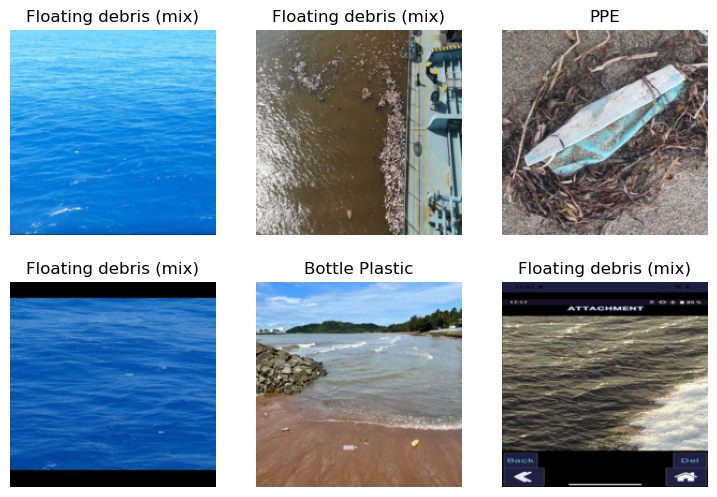

In [6]:
dls = dblock.dataloaders(DATA_DIR, bs=32)
dls.show_batch(max_n=6)

## 2. Train a vision model

As a first iteration, fine tune a pre-trained model from the [timm library](https://github.com/huggingface/pytorch-image-models).

There is a handy reference [here](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) comparing the training time vs error rate for different computer vision models.

We'll start with Resnet model since it's quick to train with decent performance.

Later, we'll train a few different families of models and ensemble the results.

In future work, we can try the bigger variants of each families. Early on, it's easiest to start with the smallest ones so we can iterate more quickly, then once we're happy with all other decisions (label cleaning, augmentation, choice of models, etc) we can gradudate to the bigger models of each family for the final model.

In [8]:
resnet_learner = vision_learner(dls, resnet18, metrics=error_rate)
resnet_learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,4.105621,2.914483,0.702703,00:18


epoch,train_loss,valid_loss,error_rate,time
0,2.683838,2.133598,0.567568,00:18
1,2.186974,1.941798,0.486486,00:18
2,1.690092,1.761449,0.418919,00:18
3,1.328111,1.751865,0.391892,00:18
4,1.097379,1.722501,0.378378,00:18


## 3. Check the model's performance

I saved some results from google images as a makeshift out-of-sample test set. These are saved in the `test_images` folder of this repo.

The performance isn't great for now since this is just a quick model over a small sample of (dubious quality) images. 

But this is still progress - we have a model running end-to-end!

In [9]:
test_img_path = Path.cwd() / 'test_images'

These are the filename of the test images:

In [10]:
test_img_filepaths = test_img_path.ls()
print(test_img_filepaths)

[Path('/Users/gurpreetjohl/workspace/python/swb_eyesea/test_images/img_plastic_bottle.png'), Path('/Users/gurpreetjohl/workspace/python/swb_eyesea/test_images/img_can.png'), Path('/Users/gurpreetjohl/workspace/python/swb_eyesea/test_images/img_plastic_bottle2.png'), Path('/Users/gurpreetjohl/workspace/python/swb_eyesea/test_images/img_rope.png')]


Let's look at one of the test images:

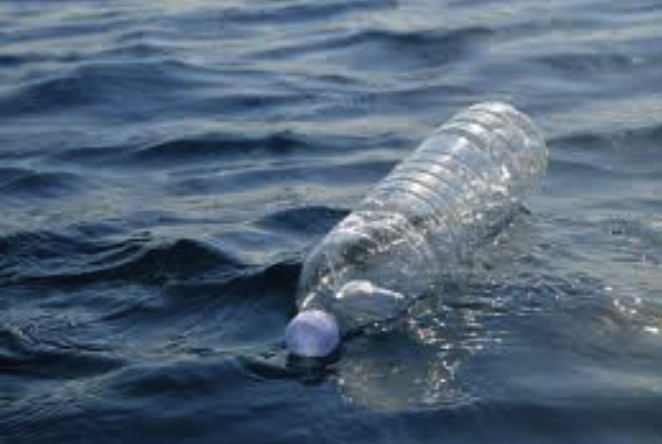

In [11]:
test_img = PILImage.create(test_img_filepaths[0])
test_img

In [12]:
resnet_learner.predict(test_img)

('Fishing Buoy',
 tensor(5),
 tensor([0.0069, 0.1248, 0.0032, 0.0042, 0.0146, 0.3213, 0.0816, 0.0046, 0.0052,
         0.0693, 0.1886, 0.0142, 0.0133, 0.0072, 0.0124, 0.1167, 0.0023, 0.0096]))

It got it wrong... But at least we've got a starting point!

## 4. Ensembling models

It was simple enough to fine-tune a Resnet model, so let's try a couple more models.

And if we have a few different independent(ish) models, we can stack the results to hopefully get some better performance.

### 4.1. Train some more models

In [13]:
convnext_learner = vision_learner(dls, convnext_tiny, metrics=error_rate)
convnext_learner.fine_tune(5)

/Users/gurpreetjohl/miniconda3/envs/eyesea/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gurpreetjohl/miniconda3/envs/eyesea/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,3.979648,2.453817,0.716216,00:29


epoch,train_loss,valid_loss,error_rate,time
0,2.445606,2.225092,0.662162,01:37
1,2.087727,1.861693,0.540541,01:37
2,1.756564,1.701287,0.500000,01:39
3,1.447531,1.652542,0.405405,01:38
4,1.260600,1.613887,0.405405,01:39


In [14]:
regnet_learner = vision_learner(dls, regnet_x_1_6gf, metrics=error_rate)
regnet_learner.fine_tune(5)


/Users/gurpreetjohl/miniconda3/envs/eyesea/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_1_6GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_1_6GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,4.232244,3.093034,0.743243,00:22


epoch,train_loss,valid_loss,error_rate,time
0,2.001530,2.249528,0.635135,00:21
1,1.779252,1.802768,0.445946,00:21
2,1.437467,1.622079,0.459459,00:21
3,1.186763,1.616985,0.432432,00:21
4,1.039295,1.579014,0.432432,00:21


### 4.2. Compare the predictions on our test image

We had a test image of a plastic bottle. How do these new models fare?

In [17]:
regnet_learner.predict(test_img)

('Can',
 tensor(2),
 tensor([3.2218e-03, 3.5059e-01, 3.5688e-01, 3.4746e-04, 1.9866e-03, 3.2378e-02,
         5.7944e-03, 5.2253e-02, 3.3787e-02, 5.8362e-02, 1.4572e-03, 5.1982e-03,
         1.0959e-02, 5.3142e-02, 1.1991e-02, 1.2731e-02, 1.1939e-03, 7.7188e-03]))

In [18]:
convnext_learner.predict(test_img)

('Fishing Gear',
 tensor(6),
 tensor([0.0341, 0.0336, 0.0817, 0.0041, 0.0130, 0.0086, 0.2749, 0.0064, 0.0282,
         0.0103, 0.2396, 0.0661, 0.0194, 0.0307, 0.0097, 0.0922, 0.0387, 0.0089]))

Still not greate...

### 4.3. Ensemble the results

We've got a few different models, so we can stack them.

There are a few different approaches we could take:

1. Take the mean of the predictions (binary 0 or 1)
2. Take the mean of the probabilities (continuous between 0 and 1) then threshold the result
3. Take the mode of the predictions (binary 0 or 1)
    
In the past, the mean approaches have tended to work better but there’s no rule as to why, so we can explore all of them.

For now, I'll take the mean of probabilities (Option 2).

In [39]:
def ensemble_predict_test_image(test_image, learners, vocab):
    """Return the predicted labe, index and probabilities for a test image given a list of learners and the DataLoader's vocab."""
    probs_list = [] 

    for learner in learners:
        probability_tensor = learner.predict(test_image)[2]
        probs_list.append(probability_tensor)

    stacked_probs = torch.stack(probs_list).mean(axis=0)
    highest_prob_idx = stacked_probs.argmax(dim=-1)
    predicted_label = vocab[highest_prob_idx]

    return (predicted_label, highest_prob_idx, stacked_probs)

In [41]:
ensemble_predict_test_image(test_image=test_img, 
                            learners=(resnet_learner, convnext_learner, regnet_learner),
                            vocab=dls.vocab)

('Bottle Plastic',
 tensor(1),
 tensor([0.0147, 0.1697, 0.1472, 0.0029, 0.0099, 0.1207, 0.1208, 0.0211, 0.0224,
         0.0460, 0.1432, 0.0285, 0.0146, 0.0303, 0.0114, 0.0739, 0.0141, 0.0087]))

We finally get the correct classification!

## 5. Addressing mislabelled items

Training a simple model (as above) and seeing which examples were most misclassified can sometimes help us narrow down mislabelled items.

I'll just use the resnet_learner for this rather than the ensemble, but the general idea is the same.

In [43]:
from fastai.interpret import Interpretation

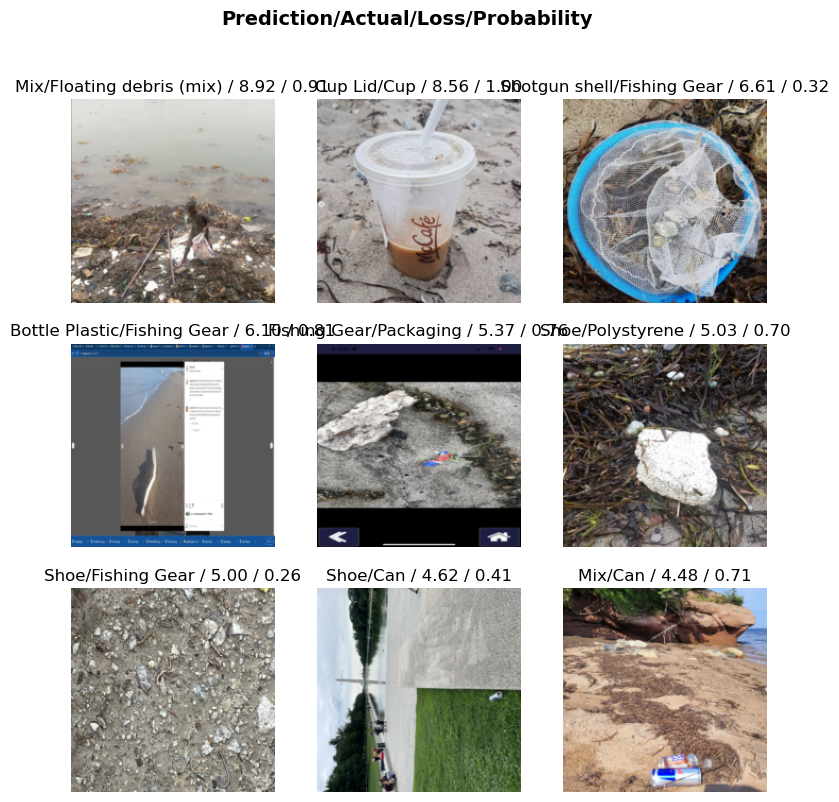

In [45]:
interp = Interpretation.from_learner(resnet_learner)
interp.plot_top_losses(9)

## 6. Data augmentation

I didn't perform any data augmentation above, but it's easy enoguh to add it.

When we loaded the DataBlock at the verey start, we can also pass `batch_tfms=aug_transforms()` which applies some default data augmentation.

Let's look at those defaults it applies. A further research area could be to play with these parameters.

In [46]:
aug_transforms?

Signature:
aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Docstring: Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.
File:      ~/miniconda3/envs/eyesea/lib/python3.10/site-packages/fastai/vision/augment.py
Type:      function

In [47]:
dblock_with_aug = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # The input and output types
    get_items=get_image_files,  # Function that returns a list of all inputs
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # How to split the training/validation set
    get_y=parent_label,  # Function that retuns the label of a given image
    item_tfms=[Resize(192, method='squish')],  # Pre-processing transforms to apply to the input images
    batch_tfms=aug_transforms()  # Data augmentation on the images using default values of aug_transforms
)

## 7. Areas to explore

A few thoughts from the initial data exploration.

1. Cleaning labels

    a. What generic high-level labels make sense? The current labels we have aren't balanced and have some overlap, so we might want to tweak these.

    b. Should be group smaller categories together into an "Other" category? We would probably need an "Other" category in practice anyway as the test set might contain new labels. Could also help balance classes.

    c. Would it work as a hierarchy of labels where we learn multiple targets? E.g. `plastic -> bottle, plastic -> bag, metal -> can, paper -> cup, etc`. Even if we "throw away" one level of the hierarchy and only use the top level, this multi-target approach often improves accuracy over a single target. E.g. training a model to learn plant species AND presence of disease in plants, then only using it for the species classification can yield better results than training a classifier on plant species alone, since we let the model learning any relations between species and disease. See for example, [here](https://youtu.be/p4ZZq0736Po?si=DwGl4__iDdWvv9lX&t=3494)

2. Fine-tune a few different pre-trained vision models. 

    a. Would this give "good enough" performance? How good is "good enough"?

    b. Probably better to fine-tune an existing model than train a classifier from scratch given the small training set and limited compute.

    c. Handy reference for comparison of different vision models: https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning

    d. An area to researhc would be to try out a different model families, sizes, hyperparameters and see what works best for our data.

3. Ensembling

    a. There are a few different approaches to ensembling a categorical variable. I only tried out Option 2, but we could compare different approaches.

        i. Take the mean of the predictions (binary 0 or 1)
        ii. Take the mean of the probabilities (continuous between 0 and 1) then threshold the result
        iii. Take the mode of the predictions (binary 0 or 1)

4. Create an effective validation set

    a. [This is a good post](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on the importance of the validation set, and the example they give (classifying fish where the boat in the background "breaks" the validation set) is very similar to ours 
    b. This could be particularly relevant for us since our data set contains different types of image, e.g. some are screenshots, sea vs land, etc. So we want to make sure out training, validation and test sets each contain a representative sample of the different types.
    c. The brute force way would be to manually split this so that the training, validation and test sets all contain representative samples, i.e. screenshots vs regular photos, sea vs land.
    d. We could get smarter and train an unsupervised model (e.g. VAE) to learn a lower-dimensional embedding, then eyeball the dimensions to see if they correspond to meaningful quantities (like screenshots vs regular photos, sea vs land etc), then split the training, validation and test sets by sampling from that.
    